**HyperTS支持解决单变量时序分类, 多变量时序分类，同时分类可以为二分类也可以为多分类任务。**

**在本NoteBook中，我们利用HpyerTS做一个时序分类任务。**

### Step 1: 首先，我们导入示例数据集**basic motions**, 并做EDA分析数据。

In [1]:
from hyperts.datasets import load_basic_motions

In [2]:
df = load_basic_motions()

In [3]:
df.head()

,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,target
0,0 0.079106 1 0.079106 2 -0.903497 3...,0 0.394032 1 0.394032 2 -3.666397 3...,0 0.551444 1 0.551444 2 -0.282844 3...,0 0.351565 1 0.351565 2 -0.095881 3...,0 0.023970 1 0.023970 2 -0.319605 3...,0 0.633883 1 0.633883 2 0.972131 3...,standing
1,0 0.377751 1 0.377751 2 2.952965 3...,0 -0.610850 1 -0.610850 2 0.970717 3...,0 -0.147376 1 -0.147376 2 -5.962515 3...,0 -0.103872 1 -0.103872 2 -7.593275 3...,0 -0.109198 1 -0.109198 2 -0.697804 3...,0 -0.037287 1 -0.037287 2 -2.865789 3...,standing
2,0 -0.813905 1 -0.813905 2 -0.424628 3...,0 0.825666 1 0.825666 2 -1.305033 3...,0 0.032712 1 0.032712 2 0.826170 3...,0 0.021307 1 0.021307 2 -0.372872 3...,0 0.122515 1 0.122515 2 -0.045277 3...,0 0.775041 1 0.775041 2 0.383526 3...,standing
3,0 0.289855 1 0.289855 2 -0.669185 3...,0 0.284130 1 0.284130 2 -0.210466 3...,0 0.213680 1 0.213680 2 0.252267 3...,0 -0.314278 1 -0.314278 2 0.018644 3...,0 0.074574 1 0.074574 2 0.007990 3...,0 -0.079901 1 -0.079901 2 0.237040 3...,standing
4,0 -0.123238 1 -0.123238 2 -0.249547 3...,0 0.379341 1 0.379341 2 0.541501 3...,0 -0.286006 1 -0.286006 2 0.208420 3...,0 -0.098545 1 -0.098545 2 -0.023970 3...,0 0.058594 1 0.058594 2 0.175783 3...,0 -0.074574 1 -0.074574 2 0.114525 3...,standing


In [4]:
print('class: ', df.target.unique())

class:  ['standing' 'running' 'walking' 'badminton']


In [5]:
print('df shape: ', df.shape)
print('cell shape: ', df.Var_1.iloc[0].shape)

df shape:  (80, 7)
cell shape:  (100,)


由数据我们可知:
- 数据结构是nested DataFrame;
- 目标列是```target```，包含四个类别['standing', 'running', 'walking', 'badminton']， 是一个多分类任务。
- 特征列是```Var_1, Var_2, Var_3, Var_4, Var_5, Var_6```是特征变量，共6个，是一个多变量分类任务。
- 共包含80个样本，每个特征的长度为100。

观测每个类(4)中每个变量(6)的时间序列特征的波动情况。

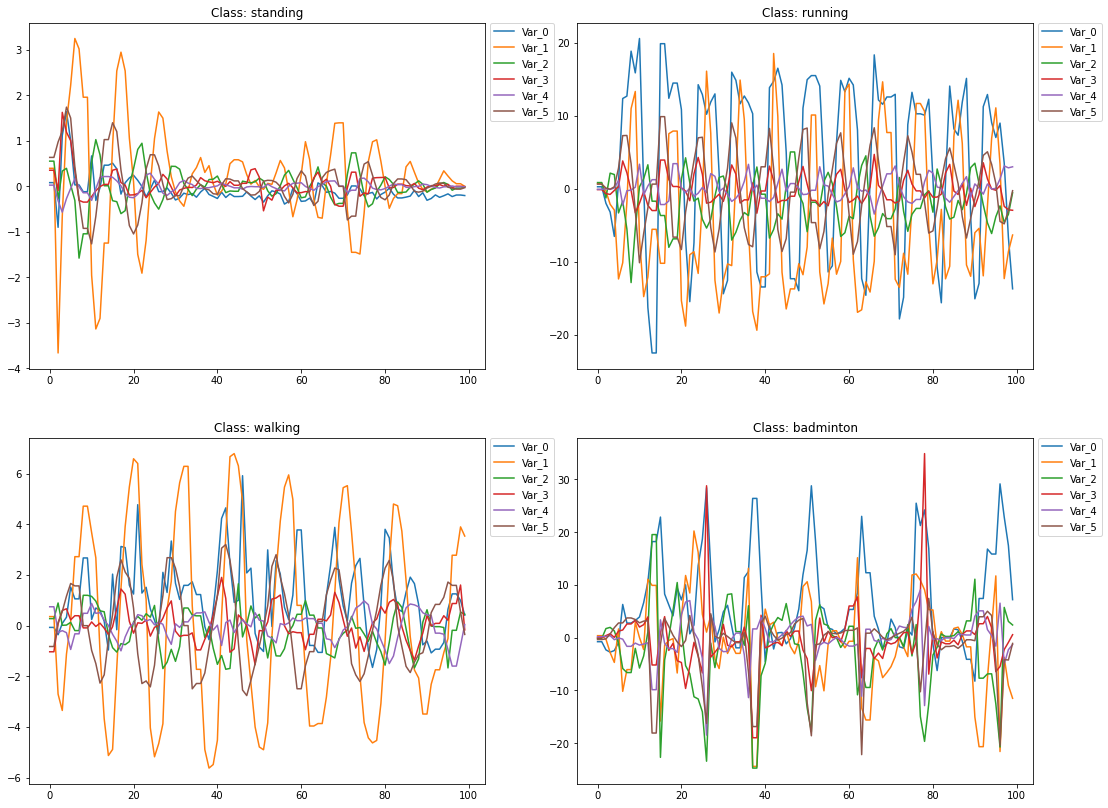

In [6]:
import matplotlib.pyplot as plt

def plot(df):
    for i in range(6):
        df[f'Var_{i+1}'].iloc[0].plot(label=f'Var_{i}')
        plt.legend(loc=2, bbox_to_anchor=(1.01, 1.0), borderaxespad=0.)

plt.figure(figsize=(18, 14))
for i, label_name in zip(range(1, 5), df.target.unique()):
    plt.subplot(2, 2, i)
    plt.title(f'Class: {label_name}')
    sub_df = df[df['target'] == label_name]
    plot(sub_df)

从以上4个图可以看出, 4个类的特征序列有一定的区分性。

对于数据集的分割，我们可以使用sklearn.model_selection内置的```train_test_split```的函数，这里hyperts也提供了相应的函数```random_train_test_split```供使用。

In [7]:
from hyperts.toolbox import random_train_test_split

train_data, test_data = random_train_test_split(df, test_size=0.2)

### Step 2: 创建实验并搜索模型。

- 为了方便且避免定义参数书写错误, 我们可以使用```hyperts.utils```中的```consts```来获取符合条件的变量名。
- 为了搜索到更好的模型，我们通过调整参数```max_trials```来增加搜索的次数。
  同时避免陷入长时间的无效搜索，我们增加早停策略，及```early_stopping_rounds```限制不提升轮数和```early_stopping_time_limit```运行总时间。
- HyperTS可以支持神经网络类的模型，我们可以选择```mode='dl'```来执行深度学习模式，在此模式下，需要使用tensorflow。如果我们的设备支持NVIDIA的GPU，可以开启GPU加入模式。

In [8]:
from hyperts.utils import consts
from hyperts import make_experiment

In [9]:
experiment = make_experiment(train_data=train_data.copy(),
                             task=consts.Task_MULTIVARIATE_MULTICALSS,
                             mode='dl',
                             dl_gpu_usage_strategy=1, # GPU
                             target='target',
                             reward_metric='accuracy',
                             max_trials=30,
                             early_stopping_rounds=10,
                             early_stopping_time_limit=3600)

model = experiment.run()

### Step 3: 获得模型的参数。

In [10]:
model.get_pipeline_params()

<bound method Pipeline.get_params of Pipeline(steps=[('data_preprocessing',
                 TSCDataPreprocessStep(data_cleaner_args={'drop_label_nan_rows': True},
                                       name='data_preprocessing')),
                ('estimator',
                 <hyperts.hyper_ts.HyperTSEstimator object at 0x000001F990FE1BA8>)])>

### Step 4: 对于测试数据(未知数据)进行预测推理。

In [11]:
X_test, y_test = model.split_X_y(test_data.copy())
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

In [12]:
y_pred

array(['badminton', 'badminton', 'walking', 'running', 'running',
       'running', 'walking', 'standing', 'standing', 'walking',
       'standing', 'walking', 'running', 'standing', 'walking',
       'standing'], dtype=object)

### Step 5: 结果评估。

在评估过程，我们可以采用HyperTS的```evaluate```函数，其对各种任务默认内置了一些评估指标。

In [13]:
results = model.evaluate(y_true=y_test, y_pred=y_pred, y_proba=y_proba)
results

,Metirc,Score
0,accuracy,1.0000
1,f1,1.0000
2,precision,1.0000
3,recall,1.0000


In [14]:
from sklearn.metrics import accuracy_score, f1_score

results = model.evaluate(y_true=y_test, y_pred=y_pred, y_proba=y_proba, 
                         metrics=[accuracy_score, f1_score, 'auc'])
results.head()

,Metirc,Score
0,accuracy_score,1.0000
1,f1_score,1.0000
2,auc,1.0000
